In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [57]:
# Load the data
votes = pd.read_csv("../data/fulldata.csv")

votes["round"] = votes["round"].astype("category")

votes = votes[votes["distance"] > 0]
votes = votes[votes["round"] == "final"]


votes = votes[votes["from_country"] != votes["to_country"]] #exclude self-votes
length_before = len(votes)
print("Rows before dropping NA Collums:", length_before)
votes.columns
votes = votes.dropna(subset=["from_country", "to_country", "distance", "total_points"])
length_after = len(votes)

print("Dropped", length_before - length_after, "rows due to missing values")
length_before = length_after
print("Rows before dropping NA after forcing numeric:", length_before)

Rows before dropping NA Collums: 34576
Dropped 0 rows due to missing values
Rows before dropping NA after forcing numeric: 34576


/tmp/ipykernel_7317/2243766077.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv("../data/fulldata.csv")


In [58]:

votes.replace("..",float("nan"),inplace=True)
print(votes['GDP per capita (current US$)_to'])
votes["GDP per capita (current US$)_from"] = pd.to_numeric(votes["GDP per capita (current US$)_from"], errors='coerce')
votes["GDP per capita (current US$)_to"] = pd.to_numeric(votes["GDP per capita (current US$)_to"], errors='coerce')
votes = votes.dropna(subset=["GDP per capita (current US$)_from", "GDP per capita (current US$)_to"])
length_after = len(votes)
print("Dropped", length_before - length_after, "rows due to missing values")
print("Rows after dropping NA:", length_after)

0        1302.53149729892
1         1397.5948032844
2                     NaN
3         1451.2850779894
4        1162.12266831735
               ...       
49323        32610.110923
49324         8575.171134
49325        27331.209495
49326        12281.505849
49328        54343.226508
Name: GDP per capita (current US$)_to, Length: 34576, dtype: object
Dropped 362 rows due to missing values
Rows after dropping NA: 34214


In [61]:
votes["GDP_Difference"] = votes["GDP per capita (current US$)_from"] - votes["GDP per capita (current US$)_to"]


In [62]:
votes.head

<bound method NDFrame.head of        Unnamed: 0  year  round from_country to_country  total_points  \
0               0  1960  final           at         fr             1   
1               1  1960  final           at         gb             3   
3               3  1960  final           at         no             1   
4               4  1960  final           at         de             2   
5               5  1960  final           at         be             1   
...           ...   ...    ...          ...        ...           ...   
49323       49323  2023  final           gb         si             1   
49324       49324  2023  final           gb         al             0   
49325       49325  2023  final           gb         pt             0   
49326       49326  2023  final           gb         rs             0   
49328       49328  2023  final           gb         de             0   

       tele_points  jury_points iso-alpha-3_from  chrstprot_from  ...  \
0              NaN          NaN 

In [63]:
votes["distance"] = votes["distance"].astype("int")
votes["distance"] = (votes["distance"] - votes["distance"].mean()) / votes[
    "distance"
].std()
votes["GDP_Difference"] = (votes["GDP_Difference"] - votes["GDP_Difference"].mean()) / votes[
    "GDP_Difference"
].std()
## Linear Effects Model



# Check the assumptions of the linear effects model


In [64]:
mixed_model = smf.mixedlm(
    formula="total_points ~ distance + GDP_Difference",
    data=votes,
    groups=votes["from_country"],
).fit()
print(mixed_model.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: total_points
No. Observations: 34214   Method:             REML        
No. Groups:       49      Scale:              17.5335     
Min. group size:  18      Log-Likelihood:     -97553.0974 
Max. group size:  1251    Converged:          Yes         
Mean group size:  698.2                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        2.930    0.030 96.731 0.000  2.871  2.990
distance         0.126    0.023  5.416 0.000  0.081  0.172
GDP_Difference  -0.014    0.028 -0.495 0.620 -0.070  0.042
Group Var        0.002    0.002                           



/home/goon/miniconda3/envs/eurovision/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


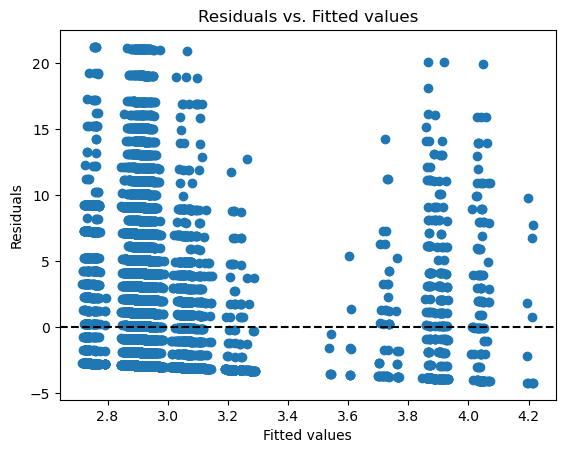

In [65]:
votes["residuals"] = mixed_model.resid
votes["fitted_values"] = mixed_model.fittedvalues

# Plot the residuals
plt.scatter(votes["fitted_values"], votes["residuals"])
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted values")
plt.axhline(y=0, color="black", linestyle="--")
plt.show()

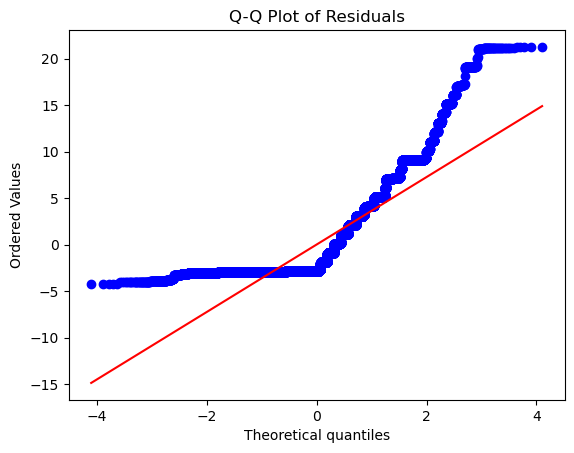

In [77]:
import scipy.stats as stats
# Assuming residuals are stored in votes["residuals"]
stats.probplot(votes["residuals"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()
